<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Web APIs & NLP

## Problem Statement

In a hypothetical scenario, Manhattan Prep has hired me as a Consultant to build a machine learning model which is able to distinguish between posts which come from the r/GRE subreddit and the r/GMAT subreddit. The company would like to leverage NLP in improving user experience. The aim is to remain a top choice for GRE and GMAT resources. 

## Executive Summary

Natural Language Processing is a tool that is increasingly being adopted by organizations in different fields to obtain raw customer feedback to better understand clients needs, and boost user experience. Manhattan Prep, a subsidiary of Kaplan Inc. is a schooling company, which amongst other services, produces top rated test preparation materials for the GRE, GMAT, LSAT and EA assessments. 

In a hypothetical scenario, the Company has hired me as a consultant to build a machine learning model which is able to accurately distinguish between posts from the GRE (r/GRE) and GMAT (r/GMAT) subreddits. The aim is to leverage this raw data, as potential feedback from its customers on the quality of its products related to both tests, which the Company can use as insights to continue to ensure that it is meeting test takers' needs. Ultimately, Manhattan Prep aims to remain a top choice for GRE and GMAT resources. 

To gather data for the analysis, a while loop was used to pull data from reddit using [Pushshift's](https://github.com/pushshift/api) API. A total of 10,000 posts and 8,500 posts were scraped from r/GRE and r/GMAT, respectively. Following data cleaning, count of data for r/GRE and r/GMAT were 9,447 posts and 8,072 posts, indicating a baseline accuracy of 54% and 46%, respectively. Titles and Self texts of each post were adopted as explanatory (X) features, while a binarized column indicative of each subreddit was adopted as the target (y) variable. Using scikit-learn's train/test split function, 25% of the dataset was set aside for assessing model performance on "unseen" data. 

Four classification models were estimated to meet the project's objective. These included a Multinomial Naive Bayes (MNB) model, a Random Forest (RF) model, and 2 logistic regression (Logreg) models. The second logistic regression model was estimated on a sub-sample of the dataset labelled "manhattan" which captured instances where "manhattan" was mentioned at least once in a self text. Utilizing VADER, a Sentiment Analysis was also conducted on this sub-sample to gauge users' overall sentiments about products related to the Manhattan Prep brand. 

All 4 models were low bias and low variance and recorded high accuracy scores. The MNB, RF and Logreg model (on overall sample) recorded 90% accuracy, while the Logreg model estimated on the Manhattan subsample had an accuracy score of 94%. Sensitivity and Specificity scores were also high across board, ranging from 80% to 98%. Findings from the VADER model were that sentiments associated with Manhattan Prep in both subreddits were neutral on average, and did not differ significantly between both subreddits. 

Overall, this study recommends the Logistic Regression model specified as the algorithm of choice for distinguishing between posts from r/GRE and r/GMAT. This is due to faster computational speed, higher sensitivity and specificity scores, relative to the other models. The study additionally recommends that deeper analysis be conducted on posts where compound sentiment scores associated with Manhattan Prep were negative, in order to uncover ways to potentially boost user experience. 



## Data

Data was obtained using [Pushshift's](https://github.com/pushshift/api) API. A total of 10,000 posts from r/GRE and 8,500 posts from r/GMAT were pulled for this analysis. More details on the method of data collection are contained in the `data collection` notebook in this repo.

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from sklearn.ensemble import RandomForestClassifier
import time

In [2]:
#reading r/gre data
gre= pd.read_csv('data/rgre.csv')
gre.head()

,subreddit,selftext,title,created_utc
0,GRE,[deleted],Part-to-Part and Part-to-Whole Ratios,1635799861
1,GRE,I understand that if you get a Hard second Qua...,Quant Scoring General Question,1635797046
2,GRE,NaN,hey guys! i’m taking my GRE tomorrow so i’m wo...,1635785347
3,GRE,Here’s a popular FMO riddle:\n\n***If a plane ...,Be sure to tackle these FMO questions before t...,1635784006
4,GRE,My GRE is on November 15. I have a full-time j...,Exam in 14 days. Need a study partner!,1635783676


In [3]:
#reading r/gmat data
gmat= pd.read_csv('data/rgmat.csv')
gmat.head()

,subreddit,selftext,title,created_utc
0,GMAT,NaN,Fortune Article | Dartmouth MBA grads going in...,1635798412
1,GMAT,Just saw some comments from the subreddit sugg...,Got 300 in mocks and I'm depressed,1635796763
2,GMAT,Hi All! \n\nI'm currently prepping through TTP...,TTP Referral,1635791148
3,GMAT,Attempted my GMAT today at test center. Got a ...,690 Q48 V36. Seeking improvement in 30 days.,1635787715
4,GMAT,"Hi, I've just finished my first Gmat exam and ...",Bad Gmat performance. Need advice,1635787521


In [4]:
#checking dimensions of each dataframe
gre.shape, gmat.shape

((10000, 4), (8500, 4))

In [5]:
#merging into one dataframe:
df= pd.concat([gre,gmat], ignore_index=True)

In [6]:
#checking dimensions of data
df.shape

(18500, 4)

## Data Cleaning

In [7]:
#checking for nulls.
df.isnull().sum()

subreddit         0
selftext       2944
title             0
created_utc       0
dtype: int64

There are nulls in the 'self text' column of the concatenated dataframe. My next instinct was to find out if this was an occurence in both the gre and gmat dataframes. 

In [8]:
#checking for nulls:
gre.isnull().sum()

subreddit         0
selftext       1673
title             0
created_utc       0
dtype: int64

In [9]:
#checking for nulls:
gmat.isnull().sum()

subreddit         0
selftext       1271
title             0
created_utc       0
dtype: int64

There are nulls in the 'self text' columns of the gre and gmat dataframes. According to https://towardsdatascience.com/classifying-reddit-posts-with-natural-language-processing-and-machine-learning-695f9a576ecb, this can be explained by instances when reddit users use only the title field. Hence, I won't be dropping rows containing nulls to avoid losing valuable information.

In [10]:
#checking for duplicates in dataframe:
df.duplicated().any()

True

In [11]:
#Confirming number of unique values in dataframe:
df.nunique()

subreddit          2
selftext       14651
title          17672
created_utc    18437
dtype: int64

The query for duplicates in the dataframe returned "True". Hence, I proceeded to check for the count of unique entries in each column. Looking at the number of unique values for "created_utc", we can see that 18,437 of 18,500 posts are probably unique given the times they were created/posted. 

However, to avoid, analysing duplicate entries, I will be dropping rows with duplicate **titles**. This is under the assumption that a title gives a definitive summary of each post and subsumes self texts.

In [12]:
#dropping duplicates
df.drop_duplicates(subset=['title'],keep='last',inplace=True)

In [13]:
#checking new dimensions of dataframe
df.shape

(17672, 4)

In [14]:
#confirming that duplicate titles were dropped
df.nunique()

subreddit          2
selftext       14239
title          17672
created_utc    17668
dtype: int64

In [15]:
#confirming number of unique titles for r/GRE
df[df['subreddit']=='GRE'].nunique()

subreddit         1
selftext       7572
title          9523
created_utc    9521
dtype: int64

In [16]:
#confirming number of unique titles for r/GMAT
df[df['subreddit']=='GMAT'].nunique()

subreddit         1
selftext       6685
title          8149
created_utc    8148
dtype: int64

In [17]:
#viewing entries where selftext column is NaN
df[df['selftext'].isna()]

,subreddit,selftext,title,created_utc
2,GRE,NaN,hey guys! i’m taking my GRE tomorrow so i’m wo...,1635785347
15,GRE,NaN,May I know how to pay for gregmat. I’m from In...,1635754787
22,GRE,NaN,Can someone help me with this question?? PPP3 ...,1635746540
25,GRE,NaN,What do you think of the Gregmat quant vs the ...,1635740356
29,GRE,NaN,Is it true that the GRE now make it alot harde...,1635701564
...,...,...,...,...
18473,GMAT,NaN,What is YOUR strategy for these kind of PS que...,1585583966
18477,GMAT,NaN,"When unemployment surges, the number of grad s...",1585537428
18492,GMAT,NaN,The At-Home GMAT: What To Expect,1585295390
18493,GMAT,NaN,Hi friends - I have a lot of students who have...,1585291815


In [18]:
#filling nulls in the 'selftext' column with the corresponding entry in the 'title' column
df["selftext"].fillna (df["title"],inplace=True)

In [19]:
#crosschecking that nulls have been filled
df.isnull().sum()

subreddit      0
selftext       0
title          0
created_utc    0
dtype: int64

In [20]:
#removing links from titles
df['title'] = df['title'].replace('http\S+', '', regex=True).replace('www\S+', '', regex=True).replace('\n\n\S+', '', regex=True)

In [21]:
#removing links from texts
df['selftext'] = df['selftext'].replace('http\S+', '', regex=True).replace('www\S+', '', regex=True).replace('\n\n\S+', '', regex=True)

I decided to fill nulls in the self text column with corresponding values in the title column, because i intend to analyze these columns seperately and there should not be a confounding issue. Secondly, this follows the earlier assumption that the empty selftext entries were from users who decided to use just the title bar in making their entry. 

In [22]:
#Binarizing subreddit column
df['subreddit']=df['subreddit'].map({'GRE':1,'GMAT':0})

In [23]:
#Checking for level of balance in both classes:
df['subreddit'].value_counts(normalize=True)

1    0.538875
0    0.461125
Name: subreddit, dtype: float64

In [24]:
#creating column for title word count
df['title_word_count']=df['title'].apply(lambda x:len(word_tokenize(x.lower())))

In [25]:
#creating column for selftext word count
df['text_word_count']=df['selftext'].apply(lambda x:len(word_tokenize(x.lower())))

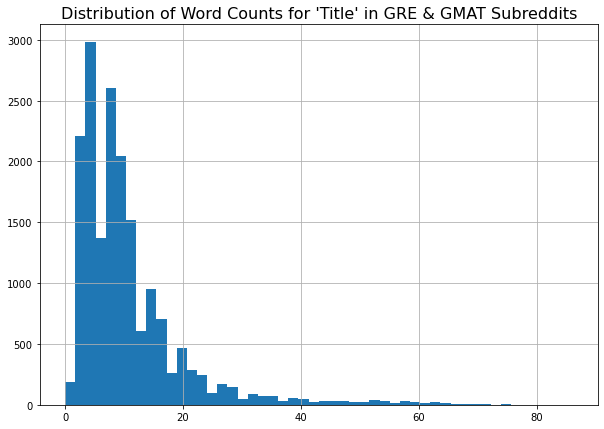

In [26]:
plt.figure(figsize=(10,7))
df['title_word_count'].hist(bins=50)
plt.title("Distribution of Word Counts for 'Title' in GRE & GMAT Subreddits", fontsize=16)
plt.savefig("Distribution of Word Counts for 'Title' in GRE & GMAT Subreddits");

As can be seen from the histogram above, the distribution of word counts for the title column is heavily skewed to the left due to the presence of extreme outliers.

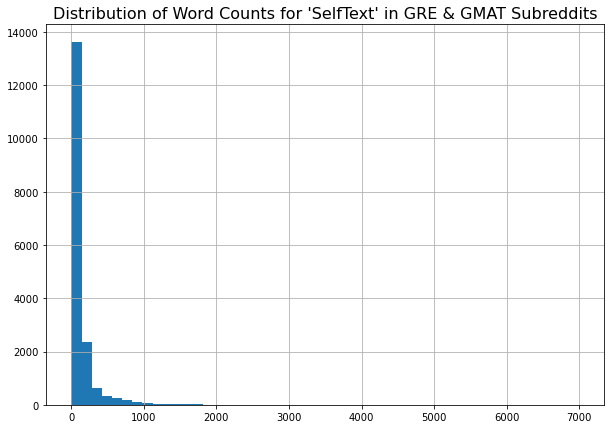

In [27]:
plt.figure(figsize=(10,7))
df['text_word_count'].hist(bins=50)
plt.title("Distribution of Word Counts for 'SelfText' in GRE & GMAT Subreddits",fontsize=16)
plt.savefig("Distribution of Word Counts for 'SelfText' in GRE & GMAT Subreddits");

The same is the case, for the self text column. Hence, we will drop entries with extreme outliers to help further analysis.

In [28]:
#displaying rows where title word count exceeds 45 words
df[df['title_word_count']>60]

,subreddit,selftext,title,created_utc,title_word_count,text_word_count
2,1,hey guys! i’m taking my GRE tomorrow so i’m wo...,hey guys! i’m taking my GRE tomorrow so i’m wo...,1635785347,75,75
607,1,What is the right solution for this question. ...,What is the right solution for this question. ...,1634043503,64,64
769,1,Somber &amp; devastated after GRE scores. Took...,Somber &amp; devastated after GRE scores. Took...,1633633570,69,69
775,1,The answer for #14 of Set 2: Medium Questions ...,The answer for #14 of Set 2: Medium Questions ...,1633626768,72,72
981,1,&amp;#x200B;\n\n,I just took the ETS powerprep free practice te...,1633176787,61,6
...,...,...,...,...,...,...
17382,0,"THE 700 CLUB: I’m compiling an unofficial, vol...","THE 700 CLUB: I’m compiling an unofficial, vol...",1592247802,64,64
17515,0,It isn't Christmas but I got a wonderful gift....,It isn't Christmas but I got a wonderful gift....,1591676124,68,68
18032,0,What am I missing?! Going through Kaplan basic...,What am I missing?! Going through Kaplan basic...,1588813848,62,62
18085,0,I teach the GMAT in San Diego &amp; I see that...,I teach the GMAT in San Diego &amp; I see that...,1588467397,65,65


In [29]:
#dropping rows where word count of title exceeds 60 words
df.drop(df[df['title_word_count']>60].index,inplace=True)

In [30]:
#displaying rows where word count of self text exceeds 1,700 words
df[df['text_word_count']>1700]

,subreddit,selftext,title,created_utc,title_word_count,text_word_count
9,1,I have had problems with silly mistakes for ye...,Slaying my Silly Mistake Demons: How I confron...,1635776294,26,1869
1451,1,Just came back from the testing center! And I ...,"Done (320, 155V + 165Q unofficial). My entire ...",1632137990,14,3077
1615,1,&amp;#x200B; Test-Day Tips: 23 Strategies for ...,GRE Test-Day Tips: 23 Strategies for Success,1631792314,8,2120
1706,1,So I gave my GRE roughly a week ago on the 5th...,V: 159 Q: 164 Ask me anything!,1631613229,10,1986
1817,1,"Disclaimer: Long Post / Short Story - 159V, 16...",My Journey to 325 (without subscriptions or co...,1631384334,10,4149
...,...,...,...,...,...,...
16706,0,The sub has grown significantly since I took t...,"780: Test Plan, Debrief, &amp; Insights",1595347069,11,1805
16715,0,"Hey Everyone, apologize for this long post, bu...",My 3 year GMAT Journey has ended - 580 to 710 ...,1595300226,14,1977
17180,0,"After finally wrapping up the GMAT last week, ...",From 710 to 770 (50Q/45V/8IR/6AWA): GMAT Study...,1593143833,21,3453
17455,0,**Summary** \nOnline Score: 710 (47/40) ...,Debrief: 650 to 710 (Q47/V40 Online),1591969910,9,3381


In [31]:
#dropping rows where self text word count exceeds 1,700 words
df.drop(df[df['text_word_count']>1700].index,inplace=True)

In [32]:
#confirming number of entries in both classes 
df['subreddit'].value_counts()

1    9447
0    8072
Name: subreddit, dtype: int64

In [33]:
#checking new dataframe dimensions
df.shape

(17519, 6)

In [34]:
#mean word count of titles by subreddit
df.groupby('subreddit')['title_word_count'].mean()

subreddit
0    10.393211
1    10.541971
Name: title_word_count, dtype: float64

Mean word count for titles were fairly equal between both subreddits, although titles in r/GRE were slightly longer on average.

In [35]:
#mean word count of selftexts by subreddit
df.groupby('subreddit')['text_word_count'].mean()

subreddit
0    116.977701
1    123.665714
Name: text_word_count, dtype: float64

Mean word counts for selftexts in both subreddits did not differ significantly. Like with titles, word count for selftexts in r/GRE were slightly longer on average than r/GMAT.

## Preprocessing

In [36]:
#setting up X & y features:
X1= df['title']
X2=df['selftext']
y= df["subreddit"]

In [37]:
#creating train test sets for title feature & specifying random_state=42 for replicability
X1_train, X1_test, y_train, y_test = train_test_split(X1,y,stratify=y,random_state=42)

In [38]:
#creating train test sets for selftext feature & specifying random_state=42 for replicability
X2_train, X2_test, y_train, y_test = train_test_split(X2,y,stratify=y,random_state=42)

In [39]:
# Instantiate CountVectorizer for title column with params
cvec_title = CountVectorizer(stop_words= 'english',ngram_range=(1,3),max_df=0.8,min_df=0.02)

In [40]:
# Instantiate CountVectorizer for selftext column with params
cvec_text = CountVectorizer(stop_words= 'english',ngram_range=(1,6),max_df=0.8,min_df=0.05)

In [41]:
# Fit & transform the vectorizer on training corpus (title column)
Xcvec_title_train = cvec_title.fit_transform(X1_train)

In [42]:
# transform the vectorizer on test corpus (title column)
Xcvec_title_test = cvec_title.transform(X1_test)

In [43]:
# Fit & transform the vectorizer on training corpus (selftext column)
Xcvec_text_train = cvec_text.fit_transform(X2_train)

In [44]:
# transform the vectorizer on test corpus (selftext column)
Xcvec_text_test = cvec_text.transform(X2_test)

In [45]:
#checking dimensions
Xcvec_title_train.shape, Xcvec_title_test.shape, Xcvec_text_train.shape, Xcvec_text_test.shape

((13139, 31), (4380, 31), (13139, 102), (4380, 102))

In [46]:
#1) storing in dataframe
Xcvec_title_train_df = pd.DataFrame(Xcvec_title_train.todense(),
                              columns=cvec_title.get_feature_names())

In [47]:
#2) storing in dataframe
Xcvec_title_test_df = pd.DataFrame(Xcvec_title_test.todense(),
                              columns=cvec_title.get_feature_names())

In [48]:
#3) storing in dataframe
Xcvec_text_train_df = pd.DataFrame(Xcvec_text_train.todense(),
                              columns=cvec_text.get_feature_names())

In [49]:
#4) storing in dataframe
Xcvec_text_test_df = pd.DataFrame(Xcvec_text_test.todense(),
                              columns=cvec_text.get_feature_names())

In [50]:
#cheking dimensions of dataframes
print(Xcvec_title_train_df.shape)
print(Xcvec_title_test_df.shape)
print(Xcvec_text_train_df.shape) 
print(Xcvec_text_test_df.shape)

(13139, 31)
(4380, 31)
(13139, 102)
(4380, 102)


In [51]:
#concactenating count vectorized X features (training set) & checking dimensions
Xcvec_train_df = pd.concat([Xcvec_title_train_df,Xcvec_text_train_df],axis=1)
Xcvec_train_df.shape

(13139, 133)

In [52]:
#concactenating count vectorized X features (test set) &checking dimensions
Xcvec_test_df = pd.concat([Xcvec_title_test_df,Xcvec_text_test_df],axis=1)
Xcvec_test_df.shape

(4380, 133)

In [53]:
y_train.shape, y_test.shape

((13139,), (4380,))

## EDA

In [54]:
#descriptive statistics
Xcvec_train_df.describe()

,advice,best,days,essay,ets,exam,gmat,gmat online,got,gre,...,ve,verbal,want,wanted,way,week,weeks,work,wrong,year
count,13139.000000,13139.000000,13139.000000,13139.000000,13139.000000,13139.000000,13139.000000,13139.000000,13139.000000,13139.000000,...,13139.000000,13139.000000,13139.000000,13139.000000,13139.000000,13139.000000,13139.000000,13139.000000,13139.000000,13139.000000
mean,0.028389,0.020321,0.022072,0.023366,0.023289,0.039653,0.190958,0.025192,0.020702,0.203136,...,0.192404,0.404293,0.140422,0.060279,0.105487,0.093462,0.085242,0.113403,0.075348,0.081741
std,0.167001,0.142177,0.154498,0.156024,0.153825,0.203550,0.412903,0.161498,0.146603,0.417572,...,0.595538,1.179582,0.438128,0.273710,0.412341,0.391455,0.359560,0.499736,0.381427,0.429025
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,3.000000,2.000000,2.000000,3.000000,...,15.000000,41.000000,7.000000,4.000000,8.000000,12.000000,6.000000,13.000000,9.000000,11.000000


In [55]:
#creating dataframe to merge count vectorized X features with target variable to facilitate EDA
Xcvec_train_df.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
all_features= pd.concat([y_train,Xcvec_train_df], axis=1)
all_features.shape

(13139, 134)

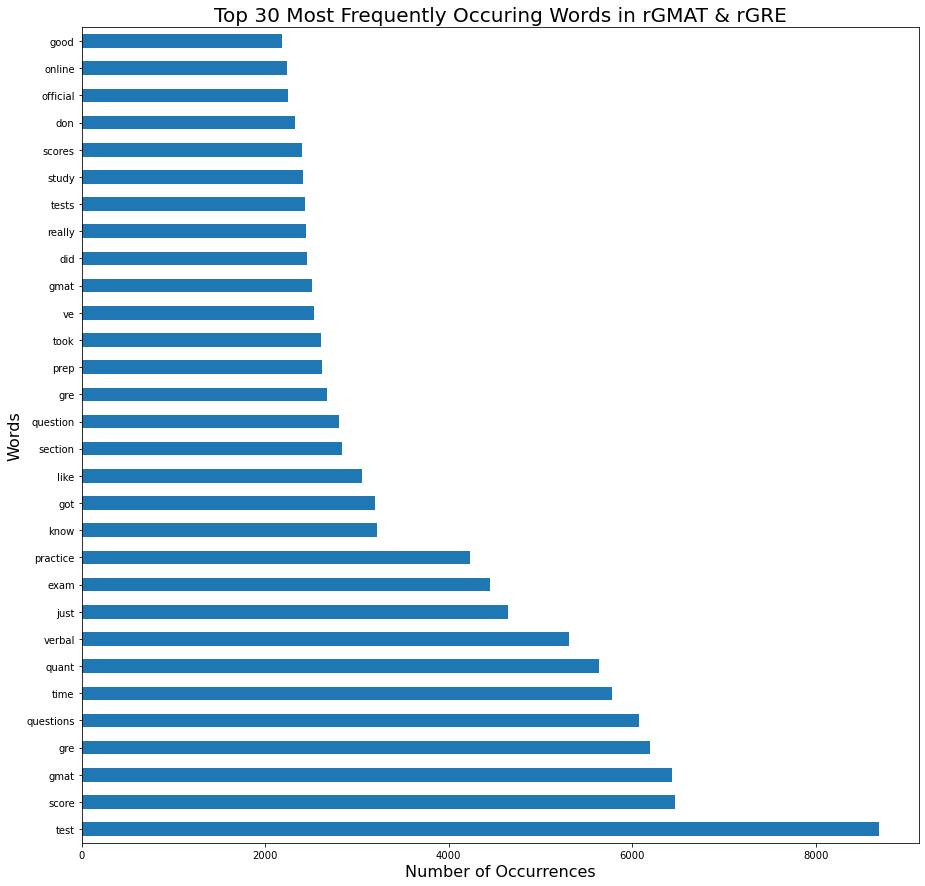

In [56]:
plt.figure(figsize=(15,15))
Xcvec_train_df.sum().sort_values(ascending=False).head(30).plot(kind='barh')
plt.xlabel("Number of Occurrences",fontsize=16)
plt.ylabel("Words",fontsize=16)
plt.title("Top 30 Most Frequently Occuring Words in rGMAT & rGRE", fontsize=20)
plt.savefig("Top 30 Most Frequently Occuring Words in rGMAT & rGRE");

Test was the most frequently reoccuring word in both subreddits, with a count of over 8,000 occurences, next were the test names themselves, GMAT, and GRE, respectively. This was followed by more generic words 'score'and 'questions'. The Quantitative section on the GRE is often referred to as 'quant'. However the math section on the GMAT could also be referred to as quant by users. Both tests have a verbal section. 

In [57]:
#setting option to display max number of columns
pd.set_option("display.max_columns",500)

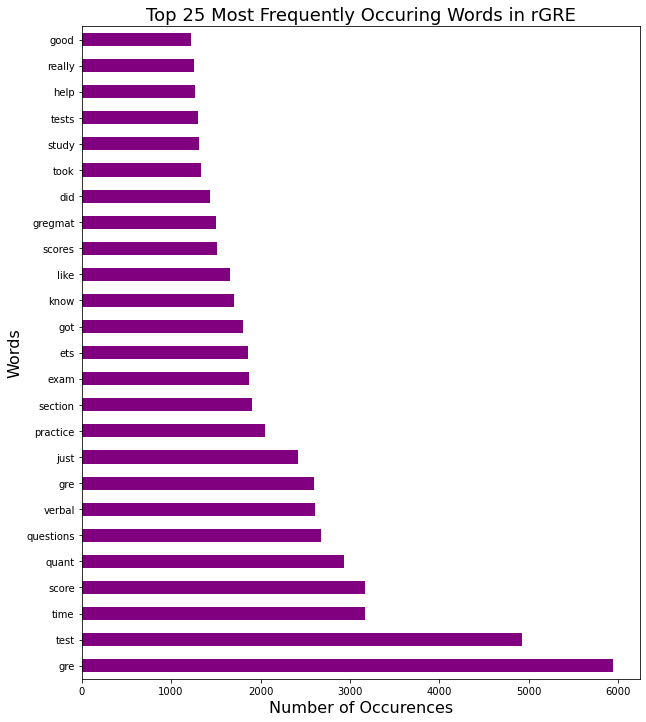

In [58]:
plt.figure(figsize=(10,12))
all_features[all_features["subreddit"]==1].iloc[:,1:].sum().sort_values(ascending=False).head(25).plot(kind='barh',color="purple");
plt.xlabel("Number of Occurences",fontsize=16)
plt.ylabel("Words",fontsize=16)
plt.title("Top 25 Most Frequently Occuring Words in rGRE",fontsize=18)
plt.savefig("Top 25 Most Frequently Occuring Words in rGRE");

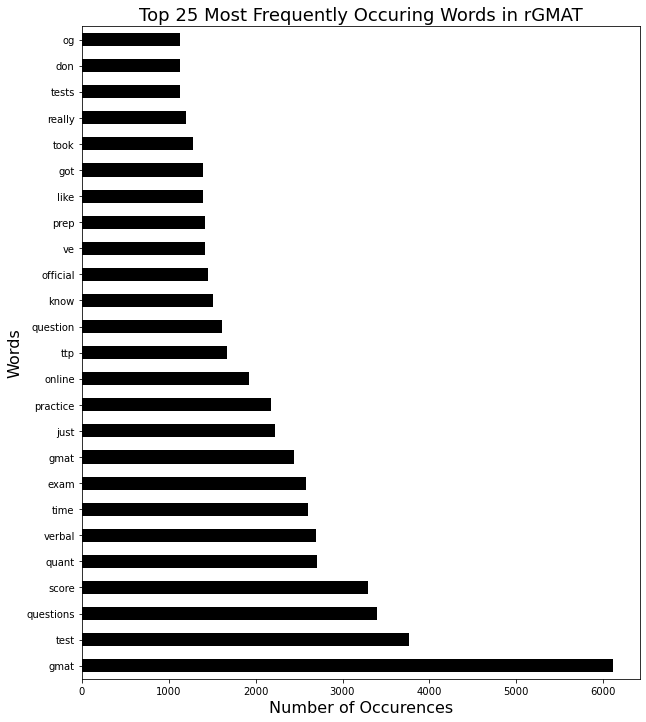

In [59]:
plt.figure(figsize=(10,12))
all_features[all_features["subreddit"]==0].iloc[:,1:].sum().sort_values(ascending=False).head(25).plot(kind='barh', color='black')
plt.xlabel("Number of Occurences",fontsize=16)
plt.ylabel("Words",fontsize=16)
plt.title("Top 25 Most Frequently Occuring Words in rGMAT",fontsize=18)
plt.savefig("Top 25 Most Frequently Occuring Words in rGMAT");

The most frequently occuring words in both the GRE and GMAT subreddits,as can be seen in the plots above, are quite similar. In fact, many of these words do not help in improving predictive power of the model. As such, I will be including some of these words as 'stop words' in the model in order to reduce "noise" in the model, and improve predictive power. 

In [60]:
#customizing list of stop words
my_words= ['test','score','scores','question','questions','time','verbal','just','tests','exam','practice','got','know','like','section',
          'did','really','study','https', "prep", "online","took"]


In [61]:
#Merging with list of english stop words
from sklearn.feature_extraction import text 

stop_words = text.ENGLISH_STOP_WORDS.union(my_words)
stop_words

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

In [62]:
# Re- Instantiate CountVectorizer for title column with params, including customized stop words
cvec_title2 = CountVectorizer(stop_words= stop_words, ngram_range=(1,3),max_df=0.8,min_df=0.02)

In [63]:
# Re- Instantiate CountVectorizer for textcolumn with params, including customized stop words
cvec_text2 = CountVectorizer(stop_words= stop_words, ngram_range=(1,6),max_df=0.8,min_df=0.02)

In [64]:
# Fit & transform the vectorizer on training corpus (title column)
Xcvec_title_train2 = cvec_title2.fit_transform(X1_train)

In [65]:
#Transform the vectorizer on test corpus (title column)
Xcvec_title_test2 = cvec_title2.transform(X1_test)

In [66]:
# Fit & transform the vectorizer on training corpus (selftext column)
Xcvec_text_train2 = cvec_text2.fit_transform(X2_train)

In [67]:
#Transform the vectorizer on test corpus (selftext column)
Xcvec_text_test2 = cvec_text2.transform(X2_test)

In [68]:
#checking dimensions
print(Xcvec_title_train2.shape)
print(Xcvec_title_test2.shape)
print(Xcvec_text_train2.shape)
print(Xcvec_text_test2.shape)

(13139, 15)
(4380, 15)
(13139, 332)
(4380, 332)


In [69]:
#1) storing in dataframe
Xcvec_title_train_df2 = pd.DataFrame(Xcvec_title_train2.todense(),
                              columns=cvec_title2.get_feature_names())

In [70]:
#2) storing in dataframe
Xcvec_title_test_df2 = pd.DataFrame(Xcvec_title_test2.todense(),
                              columns=cvec_title2.get_feature_names())

In [71]:
#3) storing in dataframe
Xcvec_text_train_df2 = pd.DataFrame(Xcvec_text_train2.todense(),
                              columns=cvec_text2.get_feature_names())

In [72]:
#4) storing in dataframe
Xcvec_text_test_df2 = pd.DataFrame(Xcvec_text_test2.todense(),
                              columns=cvec_text2.get_feature_names())

In [73]:
#crosschecking dimensions
print(Xcvec_title_train_df2.shape)
print(Xcvec_title_test_df2.shape)
print(Xcvec_text_train_df2.shape)
print(Xcvec_text_test_df2.shape)

(13139, 15)
(4380, 15)
(13139, 332)
(4380, 332)


In [74]:
#concatenating to one dataframe
Xcv_train = pd.concat([Xcvec_title_train_df2,Xcvec_text_train_df2], axis=1)
Xcv_test= pd.concat([Xcvec_title_test_df2,Xcvec_text_test_df2], axis=1)

In [75]:
#crosschecking dimensions
print(Xcv_train.shape)
print(Xcv_test.shape)
print(y_train.shape, y_test.shape)

(13139, 347)
(4380, 347)
(13139,) (4380,)


In [76]:
#saving as csv files
Xcv_train.to_csv('data/cvec_training_data.csv',index=False)
Xcv_test.to_csv('data/cvec_test_data.csv', index=False)
df.to_csv('data/data_post_cleaning.csv',index=False)

In [77]:
#creating dataframe to merge newly count vectorized X features with target variable to facilitate EDA
Xcv_train.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
all_features2= pd.concat([y_train,Xcv_train], axis=1)
all_features2.shape

(13139, 348)

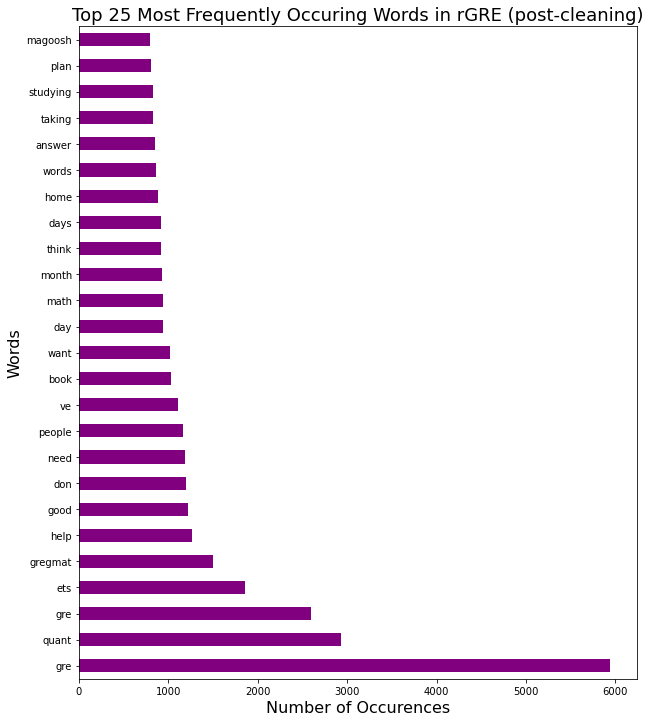

In [78]:
#displaying Top 25 Most Frequently Occuring Words in rGRE (post-cleaning)
plt.figure(figsize=(10,12))
all_features2[all_features2["subreddit"]==1].iloc[:,1:].sum().sort_values(ascending=False).head(25).plot(kind='barh',color="purple");
plt.xlabel("Number of Occurences",fontsize=16)
plt.ylabel("Words",fontsize=16)
plt.title("Top 25 Most Frequently Occuring Words in rGRE (post-cleaning)",fontsize=18)
plt.savefig("Top 25 Most Frequently Occuring Words in rGRE (post-cleaning)");

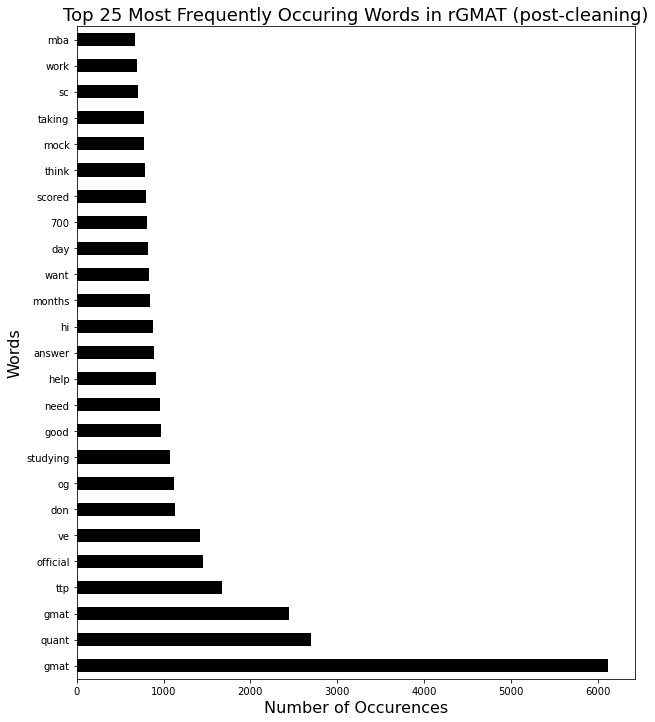

In [79]:
#displaying Top 25 Most Frequently Occuring Words in rGRE (post-cleaning)
plt.figure(figsize=(10,12))
all_features2[all_features2["subreddit"]==0].iloc[:,1:].sum().sort_values(ascending=False).head(25).plot(kind='barh',color="black");
plt.xlabel("Number of Occurences",fontsize=16)
plt.ylabel("Words",fontsize=16)
plt.title("Top 25 Most Frequently Occuring Words in rGMAT (post-cleaning)",fontsize=18)
plt.savefig("Top 25 Most Frequently Occuring Words in rGMAT(post-cleaning)");

## Modeling

In [80]:
#estimate of baseline accuracy
y_train.value_counts(normalize=True)

1    0.539234
0    0.460766
Name: subreddit, dtype: float64

### Model 1: Multinomial Naive Bayes (MNB) Model

In [81]:
#instantiating MNB model
mnb = MultinomialNB()

In [82]:
#fitting model on training data
mnb.fit(Xcv_train,y_train)

MultinomialNB()

In [83]:
#Evaluating accuracy
mnb.score(Xcv_train, y_train), mnb.score(Xcv_test, y_test)

(0.891163711089124, 0.895662100456621)

From the accuracy scores above, we can see that the model outperformed the baseline instance. The model is also low bias and low variance.

In [84]:
#generating predictions
mnb_preds= mnb.predict(Xcv_test)

In [85]:
#saving confusion matrix values for predictions made using title column
tn, fp, fn, tp = confusion_matrix(y_test, mnb_preds).ravel()

#calculating specificity & sensitivity
spec_mnb = tn / (tn + fp)
sens_mnb = tp/ (tp + fn)

print('Specificity:', spec_mnb)
print ('Sensitivity:',sens_mnb)


Specificity: 0.8473736372646185
Sensitivity: 0.936917866215072


Specificity & Sensitivity scores are also high.

### Model 2: Random Forest Model

In [86]:
#instantiate RandomForest Classifier
rf = RandomForestClassifier()

In [87]:
params = {'n_estimators': [750, 1000],
          'max_depth': [17, 19],
         'min_samples_split': [4, 5],
         'min_samples_leaf': [2, 3],
         'max_features': ['auto']}

In [88]:
#Instantiating grid search
gs = GridSearchCV(rf, params, cv=3)

In [91]:
%%time

#fitting the models
gs.fit(Xcv_train, y_train)

CPU times: user 11min 17s, sys: 9.44 s, total: 11min 26s
Wall time: 12min 3s


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [17, 19], 'max_features': ['auto'],
                         'min_samples_leaf': [2, 3],
                         'min_samples_split': [4, 5],
                         'n_estimators': [750, 1000]})

In [92]:
#Evaluating model accuracy
gs.score(Xcv_train, y_train),gs.score(Xcv_test, y_test)

(0.8971763452317528, 0.8922374429223744)

From the accuracy scores above, we can see that the model outperformed the baseline instance. The model is also low bias and low variance.

In [93]:
rf_preds = gs.predict(Xcv_test)

In [94]:
#saving confusion matrix values for predictions
tn, fp, fn, tp = confusion_matrix(y_test, rf_preds).ravel()

#calculating specificity & sensitivity
spec_rf = tn / (tn + fp)
sens_rf = tp/ (tp + fn)

print('Specificity:', spec_rf)
print ('Sensitivity:',sens_rf)


Specificity: 0.7874132804757186
Sensitivity: 0.9817950889077053


In [95]:
#obtaining the best hyperparameters
gs.best_params_

{'max_depth': 19,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 4,
 'n_estimators': 750}

In [96]:
#estimating feature importances
gs.best_estimator_.feature_importances_

array([1.10933770e-04, 1.85515808e-04, 1.14094650e-04, 6.33358251e-03,
       7.78750557e-03, 1.48638001e-01, 1.05230345e-01, 6.00749122e-03,
       1.67293702e-03, 6.30582533e-03, 1.68384441e-04, 6.90347790e-04,
       1.08399783e-04, 2.35901852e-04, 2.00069369e-02, 1.51328528e-04,
       5.49750942e-05, 7.15421458e-05, 5.68118680e-03, 1.27700920e-04,
       8.25730681e-04, 2.85538003e-04, 1.73016245e-04, 6.04366411e-04,
       7.00899122e-03, 2.15432493e-02, 5.35750041e-03, 5.76030299e-03,
       1.64444217e-04, 7.13017575e-05, 1.51516176e-04, 9.84723261e-05,
       7.75121967e-05, 2.62309232e-04, 1.40383320e-04, 5.06455992e-05,
       1.73636772e-04, 6.54696543e-04, 9.85613085e-05, 8.90787720e-05,
       1.43738193e-04, 3.61384179e-04, 6.45833071e-05, 9.82774830e-05,
       1.03722292e-04, 1.49295367e-03, 7.93837233e-05, 1.49725026e-04,
       4.84376625e-05, 4.66076191e-05, 7.56124301e-05, 6.64483277e-04,
       3.34915898e-05, 1.01010239e-04, 1.27093421e-04, 1.16197381e-04,
      

In [97]:
#transformaing to datafram
important_features = {'Column Name':Xcv_train.columns,'Feature Importance':gs.best_estimator_.feature_importances_}
fi = pd.DataFrame(important_features)

fi.head()

,Column Name,Feature Importance
0,advice,0.000111
1,best,0.000186
2,days,0.000114
3,essay,0.006334
4,ets,0.007788


In [98]:
#viewing top 50 most important features
fi.sort_values(by=['Feature Importance'], ascending = False).head(50)

,Column Name,Feature Importance
125,gmat,0.195254
5,gmat,0.148638
129,gre,0.144926
6,gre,0.105230
105,ets,0.043494
315,ttp,0.041722
132,gregmat,0.032009
25,700,0.021543
210,og,0.020058
14,ttp,0.020007


### Model 3: Logistic Regression

In [99]:
#instantiating logistic regression
logr = LogisticRegression(max_iter=20_000)

In [100]:
#fitting model
logr.fit(Xcv_train,y_train)

LogisticRegression(max_iter=20000)

In [101]:
#evaluating accuracy of model
logr.score(Xcv_train, y_train), logr.score(Xcv_test, y_test)

(0.9061572417992236, 0.8981735159817351)

From the accuracy scores above, we can see that the model outperformed the baseline instance. The model is also low bias and low variance.

In [102]:
#generating predections
logr_preds= logr.predict(Xcv_test)

In [103]:
#saving confusion matrix values for predictions
tn, fp, fn, tp = confusion_matrix(y_test, logr_preds).ravel()

#calculating specificity & sensitivity
spec_logr = tn / (tn + fp)
sens_logr = tp/ (tp + fn)

print('Specificity:', spec_logr)
print ('Sensitivity:',sens_logr)


Specificity: 0.8478691774033696
Sensitivity: 0.941151566469094


## Sentiment Analysis - VADER

I am conducting a sentiment analysis using VADER to gauge users' sentiments regarding Manhatten Prep's products.

In [104]:
#creating column to identify selftexts where manhattan is "mentioned"
df['manhattan'] = df['selftext'].apply(lambda x: 1 if 'manhattan' in word_tokenize(x.lower()) else 0)

In [105]:
#confirming
df['manhattan'].value_counts()

0    16231
1     1288
Name: manhattan, dtype: int64

In [106]:
#creating dataframe containing selftexts where manhattan is mentioned
manhattan = df[df['manhattan']==1]
manhattan.head()

,subreddit,selftext,title,created_utc,title_word_count,text_word_count,manhattan
10,1,Can someone please send me Manhattan 5LB Editi...,Does anyone have Manhattan 5LB Edition 2?,1635771957,8,12,1
27,1,About mid-August I took a manhattan prep GRE t...,Demoralized from Silly Quant Mistakes,1635726552,5,203,1
56,1,Well I wanted to give my GRE at 2nd November b...,Very anxious and panicking,1635626492,4,181,1
61,1,"First time taking it, it went alright I suppos...",Done for now - 166Q 161V 4.5AWA,1635608638,7,160,1
90,1,"Took the GRE yesterday, and the unofficial sco...",Done with the GRE - 170Q 157V,1635496590,7,1206,1


In [107]:
#checking dimensions of dataframe
manhattan.shape

(1288, 7)

In [108]:
#confirming that there are no nulls 
manhattan.isnull().sum().sum()

0

In [109]:
#converting self text column to list of strings
corpus= list(manhattan['selftext'])

In [110]:
#saving dataframe slice to csv
manhattan.to_csv('data/posts_which_mention_manhattan.csv', index=False)

In [111]:
#instantiating SIA
sia = SentimentIntensityAnalyzer()

In [112]:
#creating dataframe which has SIA scores for each selftext
sentiment = []    

for post in corpus:
    scores = sia.polarity_scores(post)
    scores['selftext'] = post
    sentiment.append(scores)

manhattan_sent = pd.DataFrame(sentiment)
manhattan_sent.head()

,neg,neu,pos,compound,selftext
0,0.000,0.796,0.204,0.3182,Can someone please send me Manhattan 5LB Editi...
1,0.235,0.667,0.098,-0.9801,About mid-August I took a manhattan prep GRE t...
2,0.223,0.712,0.065,-0.9815,Well I wanted to give my GRE at 2nd November b...
3,0.000,0.873,0.127,0.9501,"First time taking it, it went alright I suppos..."
4,0.040,0.833,0.127,0.9983,"Took the GRE yesterday, and the unofficial sco..."


In [113]:
#reading data
manhattan_csv= pd.read_csv('data/posts_which_mention_manhattan.csv')
manhattan_csv.head()

,subreddit,selftext,title,created_utc,title_word_count,text_word_count,manhattan
0,1,Can someone please send me Manhattan 5LB Editi...,Does anyone have Manhattan 5LB Edition 2?,1635771957,8,12,1
1,1,About mid-August I took a manhattan prep GRE t...,Demoralized from Silly Quant Mistakes,1635726552,5,203,1
2,1,Well I wanted to give my GRE at 2nd November b...,Very anxious and panicking,1635626492,4,181,1
3,1,"First time taking it, it went alright I suppos...",Done for now - 166Q 161V 4.5AWA,1635608638,7,160,1
4,1,"Took the GRE yesterday, and the unofficial sco...",Done with the GRE - 170Q 157V,1635496590,7,1206,1


In [114]:
#adding subreddit column to newly created SIA dataframe
manhattan_sent['subreddit']= manhattan_csv['subreddit']

In [115]:
#checking first 5 rows
manhattan_sent.head()

,neg,neu,pos,compound,selftext,subreddit
0,0.000,0.796,0.204,0.3182,Can someone please send me Manhattan 5LB Editi...,1
1,0.235,0.667,0.098,-0.9801,About mid-August I took a manhattan prep GRE t...,1
2,0.223,0.712,0.065,-0.9815,Well I wanted to give my GRE at 2nd November b...,1
3,0.000,0.873,0.127,0.9501,"First time taking it, it went alright I suppos...",1
4,0.040,0.833,0.127,0.9983,"Took the GRE yesterday, and the unofficial sco...",1


In [116]:
#checking for balance in classes
manhattan_sent['subreddit'].value_counts(normalize=True)

1    0.551242
0    0.448758
Name: subreddit, dtype: float64

In [117]:
#Computing mean normalized weighted composite (compound) score for each class 
manhattan_sent.groupby("subreddit")["compound"].mean()

subreddit
0    0.372744
1    0.417690
Name: compound, dtype: float64

In both the GRE and GMAT subreddits, "sentiments" associated with Manhattan Prep, are neutral on average. This is because the mean compound score in both categories are within the range of -0.05 to 0.05.

<Figure size 720x720 with 0 Axes>

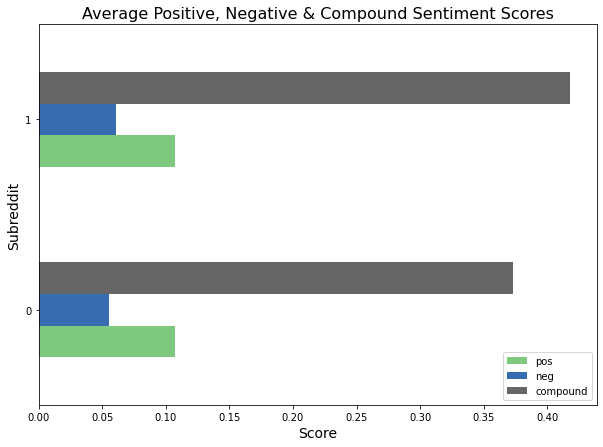

In [118]:
#Displaying Average Positive, Negative & Compound Sentiment Scores
plt.figure(figsize=(10,10))

manhattan_sent.groupby('subreddit').mean()[['pos', 'neg', 'compound']].plot(kind='barh', cmap='Accent', figsize=(10,7))
plt.title('Average Positive, Negative & Compound Sentiment Scores',fontsize=16)
plt.xlabel('Score', fontsize=14)
plt.ylabel('Subreddit', fontsize=14)
plt.savefig('Average Positive, Negative & Compound Sentiment Scores');

In [119]:
pd.set_option("display.max_colwidth",None)

In [120]:
#displaying 164 entries in r/GRE where sentiments associated with Manhattan Prep were negative
manhattan_sent[(manhattan_sent["compound"]<= -0.05) & (manhattan_sent['subreddit']==1)]

,neg,neu,pos,compound,selftext,subreddit
1,0.235,0.667,0.098,-0.9801,"About mid-August I took a manhattan prep GRE test as got 161 Q. Since then I've worked through the whole 5lb book, repeating sections/problems I did poorly on until I felt I had the concepts down. I took the Power Prep 1 test, and got a 162 Q, missing 3 problems in both quant sections. I felt like I did better both on time and knowing the material (didn't encounter any problems that stumped me, just a few I was unsure about) than my earlier test, but I only managed to improve by 1 point. Even worse, the questions I missed weren't ones I was iffy about, I just made really stupid errors on problems I felt confident about. not sure how to approach this...I feel like I've tapped out the 5lb book, and dumb errors wasn't something I really struggled with during practice. I'm worried I'm going to run out of practice problems before I can get the score I want. else have this issue? Any way you approached it besides just drilling more problems?",1
2,0.223,0.712,0.065,-0.9815,"Well I wanted to give my GRE at 2nd November but unfortunately due to some reasons I wasn't prepared enough to give it so I decided to postpone the date , so Today I logged onto the ets website to postpone my date for another 2 weeks then I got to know that I can't postpone the date 4 days prior to exam , there's literally just 2 days remaining for the exam and I can't reach 300 for my mocks , my first Kaplan mock : 153Q 142V ,my second Kaplan mock : 155Q 144V , I am very scared about tanking my first GRE attempt I know you can give more attempts but I am scared that it might hinder my application process , and can someone suggest me ways to improve quants : I solved Manhattan 5lb book , I am aiming for the score of 310 , according to me that's the most I can do , my verbal section is very weak idk what shall I do to improve it",1
5,0.151,0.738,0.111,-0.4860,"I feel more comfortable with most quant topics, but by far these three areas are my weakest, especially probability. I have the 5lb Manhattan book and the complete ETS OG. I was wondering where I might find practice problems online that can help me in these areas.",1
8,0.122,0.774,0.103,-0.3463,"I've solved Manhattan 5lb as well as quant section of Gregmat, watched Greg's concept videos wherever I was weak and saw all of his tips and tricks videos. Inspite of that my quant score is consistently low in mocks. Verbal 152 Quant 154\nPP2- Verbal 153 Quant 159 test 1- Verbal 157 Quant 153 also maintaining an error log and keep solving sections which are harder for me. But my quant score seems to be stuck and I need to get to at least 162-164 for getting into the universities I'm aiming for. I haven't booked the GRE yet, I'm intending to take it early December. I be doing more timed tests? Is it worth solving big book quant at this point? Which material should I use now? suggestion regarding this will be appreciated because the low quant score is really hurting my self esteem and I need to get better at it somehow before I run out of ETS mock tests.",1
9,0.122,0.878,0.000,-0.8168,I have my GRE in 10 days and right now i am exhausted with verbal material \ndone with every section in ETS verbal book and ETS OG book and also done with manhattan RC and Text completion ( but i saw on GregMat's video Manhattan and Kaplan's verbal aint that good like GRE level) \nSO ANY VERBAL MATERIAL OF GRE LEVEL OTHER THAN ETS OG AND VERBAL BOOK????,1
...,...,...,...,...,...,...
692,0.110,0.822,0.068,-0.5994,"Hello, I took up the GRE Test and managed to score 152 in Quants and 148 in Verbal. Despite referring to Manhattan 5LB, Official ETS Guides, Greg Mat Strategies, ended up with a low score far from what I planned to achieve(320). I need to restructure my approaches and carefully drill areas of weakness. As of now, I am clueless as to how I should devise a study plan. Also, the mocks provided by Princeton, Manhattan, and Kaplan are not even close to what I experie

In [121]:
#displaying 504 entries in r/GRE where sentiments associated with Manhattan Prep were positive
manhattan_sent[(manhattan_sent["compound"] >= 0.05) & (manhattan_sent['subreddit']==1)]

neg    neu    pos  compound  \
0    0.000  0.796  0.204    0.3182   
3    0.000  0.873  0.127    0.9501   
4    0.040  0.833  0.127    0.9983   
6    0.084  0.746  0.170    0.9779   
7    0.070  0.844  0.086    0.4773   
..     ...    ...    ...       ...   
703  0.016  0.871  0.113    0.9892   
704  0.053  0.862  0.085    0.2918   
705  0.055  0.828  0.117    0.9604   
706  0.083  0.825  0.092    0.8493   
709  0.025  0.803  0.171    0.9942   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [122]:
#displaying 139 entries in r/GMAT where sentiments associated with Manhattan Prep were negative
manhattan_sent[(manhattan_sent["compound"]<= -0.05) & (manhattan_sent['subreddit']==0)]

,neg,neu,pos,compound,selftext,subreddit
711,0.139,0.782,0.078,-0.4933,I have purchased manhattan gmat 7th edition books and want some video lectures to learn from it. I'm confused between manhattan and TTP. I'm very weak at quants but i have heard TTP course is very long and has some incessantly problems. Please suggest which one should i prefer.,0
717,0.093,0.826,0.081,-0.6939,"I took my GMAT yesterday and I was overwhelmingly thrilled to get a 720. I thought I would share my GMAT journey for two reasons: 1- To give some hope and guidance to those struggling to get their scores up and 2- To give myself a much earned pat on the shoulder after 3 months of studying. thing to note is that English is actually my third language after Arabic and French, and I only started learning English when I was 8 years old. As you will see in this post, language is not my strongest asset and that did certainly reflect with a poor starting point on verbal with a V28. My target score was therefore around 660+, and I would have been more than thrilled with a 680. June: took my first mock test, scored 580 (Q40, V28). Given my poor verbal performance, I decided to purchase Manhattan. I found the Quant and SC sections to be very helpful, especially a few strategies in Quant that really just put you on the Q48+ level. finishing my Manhattan review, I took a Manhattan CAT in which I scored a 620. Realizing that Manhattan CATs are generally more difficult than the real thing, I didn't let the poor score dishearten me. I went on to practice questions from the official guide, and took my second official exam around mid-July. Scoring 640 (Q48, V30) on my second official practice test was such a disappointment that I actually needed a break from studying to reassess my strategies. I took a month break and restarted studying around mid-August. In the past few months, I did the following: I reset my Official Guide questions and repeated the questions again. I reviewed my summary sheet from Manhattan prep. I kept an error log on all the idioms, formulas and strategies that I had missed the first time. I reset the official guide and took the Medium and Hard questions AGAIN. I took all the free practice tests online ( Veritas, Princeton, Kaplan ) and the remaining 5 MGMAT practice tests within 2-3 weeks. This really helped practice my pace, my SC pace got much better and I was able to spend more time on CR and RC questions. I was scoring in the 650 to 670 range on these exams. On my last week, I reviewed my error log and summary again. Took the exam on the weekend and scored my highest ever scores in both sections (Q49,V38). takeaways: Practice practice practice. That was a real game changer for me. Don't be discouraged by a few low scores. It's just part of the process. Repeat questions you didn't get right the first time after a while. I found that in many instances I would do the same mistake again, although I had read and understood the solutions before. Finally, don't ignore IR and AWA for too long. Despite having exceeded my personal target and expectations on verbal quant, I was still disappointed with a very low IR score. During the exam, I focused a lot on the first 10 questions in Verbal to make sure I got them right. This sub has a lot of amazing people who have encouraged me throughout the way. Use it! I always came here after a disappointing score. you all and good luck on your journey!",0
719,0.139,0.768,0.093,-0.7050,"Took my 3rd Gmat today… first two tests were very “raw” at 590 (Q44 V28), and 610 (Q42 V33)… during those months of studying I had official GMAT mock exams in high 670-690 so already frustrated there with such a drop off in performance. The last 2 months I’ve had manhattan prep tutor who has helped a lot. I’ve had similar mock exams scores but felt my consistency much higher (higher floor). Felt I had done all the right preparation, but unfortunately came away with a 650 (Q48 V31). 650 isn’t terrible, an improvement from previous of

In [123]:
#displaying 410 entries in r/GMAT where sentiments associated with Manhattan Prep were positive
manhattan_sent[(manhattan_sent["compound"]>= 0.05) & (manhattan_sent['subreddit']==0)]

,neg,neu,pos,compound,selftext,subreddit
710,0.000,0.888,0.112,0.9366,"Hi, I've just finished my first Gmat exam and I scored 640 (Q47 V31 IR8). When I saw the score I was pretty surprised tbh because I felt that the exam was going well. have been studying for 2 month with an average of 15 hours of study per week. I've studied from Manhattan prep. guides and from official gmat 2020 book. is the list of all the simulation test I took since I started studying: MGMAT1 670 (Q46 V35 IR8) Official Practice1 770 (Q51 V44 IR8) MGMAT2 640 (Q46 V32 IR6,6) MGMAT3 710 (Q45 V41 IR5,9) MGMAT4 710 (Q47 V40 IR5,9) MGMAT5 670 (Q44 V37 IR4,5) Official Practice2 700 (Q49 V36 IR8) GMAT 640 (Q47 V31 IR8) going to try again on the 17th of November but I need some advice in order to improve my verbal score. Thanks for the help.",0
712,0.090,0.722,0.188,0.9928,"I'm too lazy to scan it and upload a pic, but I got a 760 today. Q50 V42 IR6. This is going to be filled with a bunch of grammatical mistakes cause my brain is fried. I started my GMAT journey around July and have studied pretty much every day since then. I took my first exam official mock in July and scored a 530. I was really discouraged because I wasn't as good at math/reading as I thought I was. After I got over my sadness, I got to work. I first bought the MGMAT books that came with the 6 CATS and the 2022 official guide. I worked through the MGMAT and took my first practice test(Kaplan free test), which wasn't great: 630. After that, I realized that I was still struggling with some quant topics, so I knew I needed to change something. That's when I found TTP. isn't an ad. I'm not getting paid. I just want to be completely honest and save you guys time and money. TTP is 100% the best GMAT prep. It takes forever to complete. I didn't even finish it before I took my exam. I only completed the quant and sentence correction sections. It is so comprehensive and lengthy; but it is well worth it. I truly believe anyone can get a 700+ if he/she completes TTP and reviews the material regularly. I had several hundred flash cards that I reviewed daily by the time I got to my test date. I took 4 practice exams in total. 530 -&gt; 630 kaplan -&gt; 640 MGMAT 1 -&gt; 740 official practice test #3. Take as many as you can afford on the mba website. It's important to get your timing down. advice is to just stay focused and determined. I have never been amazing at standardized testing or school, but I did really well. I think I got like a 1390/1600 on the SAT in high school and was like top 50% of my class lol. I know it's expensive but TTP is definitely the best resource for GMAT prep. If you are having trouble paying for prep material, shoot me a dm. I have the 2022 GMAT official guide, Manhattan advanced quant (untouched), MGMAT ALL THE GMAT books, and Manhattan strategy books. I'm willing to give these away if you pay for shipping. Happy studying! judge me for grammar :)",0
713,0.000,0.865,0.135,0.8880,"Hi all, I’ve been studying not so consistently for over a year now and just got a 650 on a practice test. I was 94 percentile verbal, 28 quant, so I clearly need to prioritize quant for now. I’m aiming for 700+ and timed out on the Manhattan self study online program, but completed it. Any advice on next steps?? Hone in further on Manhattan or try another course to improve quant? Appreciate any suggestions!",0
714,0.086,0.764,0.150,0.9557,"I think maybe I overestimated my ability to get into an mba program. I can’t believe after 6 months I ended up with a 550(Q35 V27) when my target was 650+ on first attempt and 700 on the next(I think I’ll be greedy to think I can get better than a 700) Used: spent about 4+ months on TTP Quant only and honestly I thought it was great. Scored over 85% on global test and in my 6 official mocks, my lowest Q was 42 and highest was 48 but I ended up with a Q35 on the official?!??? wanted to try TTP verbal but honestly I was exhausted from the quant material. It was just soo

### Preprocessing

In [124]:
#setting up X and y
Xm = manhattan_sent[['selftext','compound']]
ym = manhattan_sent['subreddit']

In [125]:
#Establishing baseline accuracy
ym.value_counts(normalize=True)

1    0.551242
0    0.448758
Name: subreddit, dtype: float64

In [126]:
#Creating train and test sets
Xm_train, Xm_test, ym_train, ym_test = train_test_split(Xm,ym, random_state = 42, stratify=ym)

In [127]:
#confirming dimensions
print(Xm_train.shape, ym_train.shape)
print(Xm_test.shape, ym_test.shape)

(966, 2) (966,)
(322, 2) (322,)


In [128]:
#Instantiating count vectorizer using the same parameters as before
cvec_m = CountVectorizer(stop_words = stop_words, ngram_range=(1,6),max_df=0.8,min_df=0.05)

Xm_train_cv = cvec_m.fit_transform (Xm_train['selftext'])
Xm_test_cv = cvec_m.transform(Xm_test['selftext'])

In [129]:
#tranforming to dataframe
Xm_trainCV_df = pd.DataFrame(Xm_train_cv.todense(), columns = cvec_m.get_feature_names())
Xm_testCV_df = pd.DataFrame(Xm_test_cv.todense(), columns = cvec_m.get_feature_names())

In [130]:
#confirming dimensions of dataframe
print(Xm_trainCV_df.shape)
print(Xm_testCV_df.shape)

(966, 277)
(322, 277)


In [131]:
#resetting indices
Xm_trainCV_df.reset_index(drop=True, inplace=True)
Xm_train.reset_index(drop=True, inplace=True)
Xm_testCV_df.reset_index(drop=True, inplace = True)
Xm_test.reset_index(drop=True, inplace=True)

In [132]:
#Concactenating with Xm_train and Xm_test in order to add sentiment scores to dataframe
X_train_final = pd.concat([Xm_trainCV_df, Xm_train], axis =1)
X_test_final = pd.concat([Xm_testCV_df, Xm_test], axis =1)

In [133]:
#Dropping self text column
X_train_final.drop(columns = 'selftext', inplace= True)
X_test_final.drop(columns= 'selftext', inplace=True)

In [134]:
#confirming dimensions of final train & test set
print(X_train_final.shape, X_test_final.shape)

(966, 278) (322, 278)


### Modeling

In [135]:
#Instantiate logistic regression
logr_m = LogisticRegression(max_iter=10_000)

In [136]:
#fitting model
logr_m.fit(X_train_final, ym_train)

LogisticRegression(max_iter=10000)

In [137]:
#scoring model
logr_m.score(X_train_final, ym_train), logr_m.score(X_test_final, ym_test)

(0.9937888198757764, 0.9440993788819876)

The model is a low bias and low variance model, also a slight increase in variance can be observed relative to the other models.

In [138]:
#generating predictions
preds_manhattan = logr_m.predict(X_test_final)

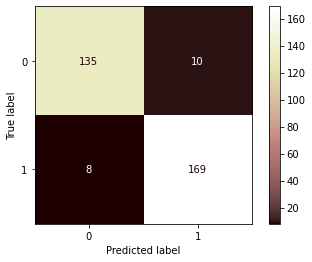

In [139]:
#Saving & generating confusion matrix values
tn, fp, fn, tp = confusion_matrix(ym_test, preds_manhattan).ravel()

plot_confusion_matrix(logr_m, X_test_final, ym_test, cmap='pink', values_format='d');


In [140]:
#Calculating Specificity & Sensitivity
spec_m = tn / (tn + fp)
sens_m = tp/ (tp + fn)

print(spec_m)
print(sens_m)

0.9310344827586207
0.9548022598870056


# Conclusion & Recommendation

The study estimated 4 classification models in attempting to accurately classify posts from r/GRE and r/GMAT. All 4 models were low bias and low variance and recorded high accuracy scores. The MNB, RF and Logreg model (on the overall sample) recorded 90% accuracy, while the Logreg model estimated on the Manhattan subsample had an accuracy score of 94%. Sensitivity and Specificity scores were also high across board, ranging from 80% to 98%. Findings from the VADER model were that sentiments associated with Manhattan Prep in both subreddits were neutral on average, and did not differ significantly between both subreddits. 

Overall, this study recommends the Logistic Regression model specified as the algorithm of choice for distinguishing between posts from r/GRE and r/GMAT. This is due to faster computational speed, higher sensitivity and specificity scores, relative to the other models. The study additionally recommends that deeper analysis be conducted on posts where compound sentiment scores associated with Manhattan Prep were negative, in order to uncover ways to potentially boost user experience. 

